# Предсказание вероятности клика по рекламному объявлению

**Краткое описание**

Требуется получить на выходе прогноз с высокой точностью вероятности клика по рекламному объявлению.
<br>На предикт ML модели выдается выборка объявлений доступных в текущий момент к показу, модель выдает по ним вероятность клика.

**Задача**

- Выбор модели для получения предсказаний.
- Обосновавние выбора

**План выполнения**
- Знакомство с данными
- Исследовательский анализ данных
- Предобработка данных
- Разработка дополнительных признаков (при необходимости)
- Построение baseline
- Обучение нескольких моделей
- Выбор лучшей модели
- Проверка лучшей модели на отложенной выборке
- Проверка важности признаков
- Заключение о проделанном исследовании

**Описание данных**
- `region_id` - id региона показа
- `city_id` - id города
- `tags_cont` - значение контекстного таргетинга
- `tags_bhv` - значение таргетинга по поведению
- `rubrica` - тематика объявления
- `rate` - ставка в рублях объявления
- `ctr_sort` - значение ctr объявления
- `rv_perc` - процент видимости объявления
- `slider` - тип рекламного блока
- `position_type` - значение позиции рекламного блока на странице сайта

**Метрики для оценки качества модели**
- основная метрика - `ROC AUC`
- дополнительная - `F1`

## Установка зависимостей

In [63]:
# !pip install pandas
# !pip install seaborn
# !pip install phik
# !pip install category_encoders
# !pip install python-dotenv
# !pip install mlflow
# !pip install psycopg2-binary
!pip freeze > requirements.txt

  Using cached psycopg2_binary-2.9.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached psycopg2_binary-2.9.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)


In [68]:
import os
import mlflow
import pandas as pd
import seaborn as sns
import psycopg2 as psycopg
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from matplotlib.gridspec import GridSpec
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

Объявление глобальных переменных

In [91]:
DATA_DIR = 'data'
ASSETS_DIR = 'assets'
RANDOM_STATE = 42
TEST_SIZE = 0.1
EXPERIMENT_NAME = 'click_pred'

load_dotenv()
connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_MLFLOW_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}
TRACKING_SERVER_PORT = os.getenv("TRACKING_SERVER_PORT")
TRACKING_SERVER_HOST = os.getenv("TRACKING_SERVER_HOST")

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
pd.options.mode.copy_on_write = True

sns.set_theme(style='white', palette='husl')

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

## Знакомство с данными

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR, 'dataset.csv'))
data_y23 = pd.read_csv(os.path.join(DATA_DIR, 'dataset_2023_10_30.csv'))

In [4]:
def data_review(dataset):
    '''
    на вход принимает датафрейм,
    выводит общую обзорную информацию
    '''
    print('Общая информация о наборе данных:')
    dataset.info()
    print()
    print('Первые пять строк набора данных:')
    display(dataset.head())
    print()
    print(f"количество полных дубликатов строк: {dataset.duplicated().sum()}")
    print()
    print(f"""количество пропущенных значений: 
    {dataset.isna().sum()}""")
    print()
    print('Вывод количества уникальных записей в каждом числовом признаке:')
    for column in dataset.select_dtypes(include=['int', 'float']).columns:
        unique_values = dataset[column].nunique()
        print(f"Количество уникальных записей в признаке '{column}': {unique_values}")

### dataset

In [5]:
data_review(data)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803526 entries, 0 to 803525
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region_id      803526 non-null  int64  
 1   city_id        803526 non-null  int64  
 2   tags_cont      803526 non-null  float64
 3   tags_bhv       803526 non-null  float64
 4   rubrica        803526 non-null  float64
 5   rate           803526 non-null  float64
 6   ctr_sort       803526 non-null  float64
 7   rv_perc        803526 non-null  float64
 8   slider         803526 non-null  int64  
 9   position_type  803526 non-null  int64  
 10  target         803526 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 67.4 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,590,0.0,0.500,1.812,1.7,1.3072,66.41,1,0,1
1,53,577,0.0,0.000,0.000,4.8,0.6568,46.79,1,0,1
2,48,0,0.0,0.000,1.950,1.7,1.3072,66.41,1,0,1
3,20,596,0.0,1.103,0.000,1.7,1.3072,94.44,0,0,1
4,290,0,0.0,0.750,0.000,1.0,1.1369,77.69,0,0,1



количество полных дубликатов строк: 255574

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 228
Количество уникальных записей в признаке 'city_id': 174
Количество уникальных записей в признаке 'tags_cont': 1527
Количество уникальных записей в признаке 'tags_bhv': 4687
Количество уникальных записей в признаке 'rubrica': 3153
Количество уникальных записей в признаке 'rate': 64
Количество уникальных записей в признаке 'ctr_sort': 3085
Количество уникальных записей в признаке 'rv_perc': 5238
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 26
Количество уникальных записей в признаке 'target': 2


### dataset_23

In [6]:
data_review(data_y23)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648184 entries, 0 to 648183
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region_id      648184 non-null  int64  
 1   city_id        648184 non-null  int64  
 2   tags_cont      648184 non-null  float64
 3   tags_bhv       648184 non-null  float64
 4   rubrica        648184 non-null  float64
 5   rate           648184 non-null  float64
 6   ctr_sort       648184 non-null  float64
 7   rv_perc        648184 non-null  float64
 8   slider         648184 non-null  int64  
 9   position_type  648184 non-null  int64  
 10  target         648184 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 54.4 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,617,0.0,0.000,0.000,26.25,0.6608,89.97,0,0,1
1,284,0,0.0,0.000,1.750,1.50,1.8803,27.31,0,0,1
2,157,0,0.0,2.576,1.488,0.70,1.3899,78.42,1,0,1
3,228,0,0.0,0.000,0.000,0.75,1.6981,7.75,0,21,1
4,51,579,0.0,0.000,0.000,1.60,1.3530,77.69,0,0,1



количество полных дубликатов строк: 205732

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 226
Количество уникальных записей в признаке 'city_id': 183
Количество уникальных записей в признаке 'tags_cont': 7054
Количество уникальных записей в признаке 'tags_bhv': 8622
Количество уникальных записей в признаке 'rubrica': 2732
Количество уникальных записей в признаке 'rate': 76
Количество уникальных записей в признаке 'ctr_sort': 3364
Количество уникальных записей в признаке 'rv_perc': 5673
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 24
Количество уникальных записей в признаке 'target': 2


### Выводы
- оба набора данных представлены исключительно числовыми данными;
- в обоих наборах примерно 30% строк являются повторами;
- в наборах отсутствуют идентификаторы рекламных объявлений;
- ввиду схожести наборов и отсутствия идентификаторов принимаю решение их объединить

### common_df

In [7]:
df = pd.concat([data, data_y23], axis=0, ignore_index=True)

In [8]:
data_review(df)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451710 entries, 0 to 1451709
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   region_id      1451710 non-null  int64  
 1   city_id        1451710 non-null  int64  
 2   tags_cont      1451710 non-null  float64
 3   tags_bhv       1451710 non-null  float64
 4   rubrica        1451710 non-null  float64
 5   rate           1451710 non-null  float64
 6   ctr_sort       1451710 non-null  float64
 7   rv_perc        1451710 non-null  float64
 8   slider         1451710 non-null  int64  
 9   position_type  1451710 non-null  int64  
 10  target         1451710 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 121.8 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,590,0.0,0.500,1.812,1.7,1.3072,66.41,1,0,1
1,53,577,0.0,0.000,0.000,4.8,0.6568,46.79,1,0,1
2,48,0,0.0,0.000,1.950,1.7,1.3072,66.41,1,0,1
3,20,596,0.0,1.103,0.000,1.7,1.3072,94.44,0,0,1
4,290,0,0.0,0.750,0.000,1.0,1.1369,77.69,0,0,1



количество полных дубликатов строк: 461322

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 245
Количество уникальных записей в признаке 'city_id': 183
Количество уникальных записей в признаке 'tags_cont': 7301
Количество уникальных записей в признаке 'tags_bhv': 8813
Количество уникальных записей в признаке 'rubrica': 3843
Количество уникальных записей в признаке 'rate': 95
Количество уникальных записей в признаке 'ctr_sort': 5584
Количество уникальных записей в признаке 'rv_perc': 7679
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 26
Количество уникальных записей в признаке 'target': 2


## Исследовательский анализ данных

In [9]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print('произведено удаление дубликатов строк')

произведено удаление дубликатов строк


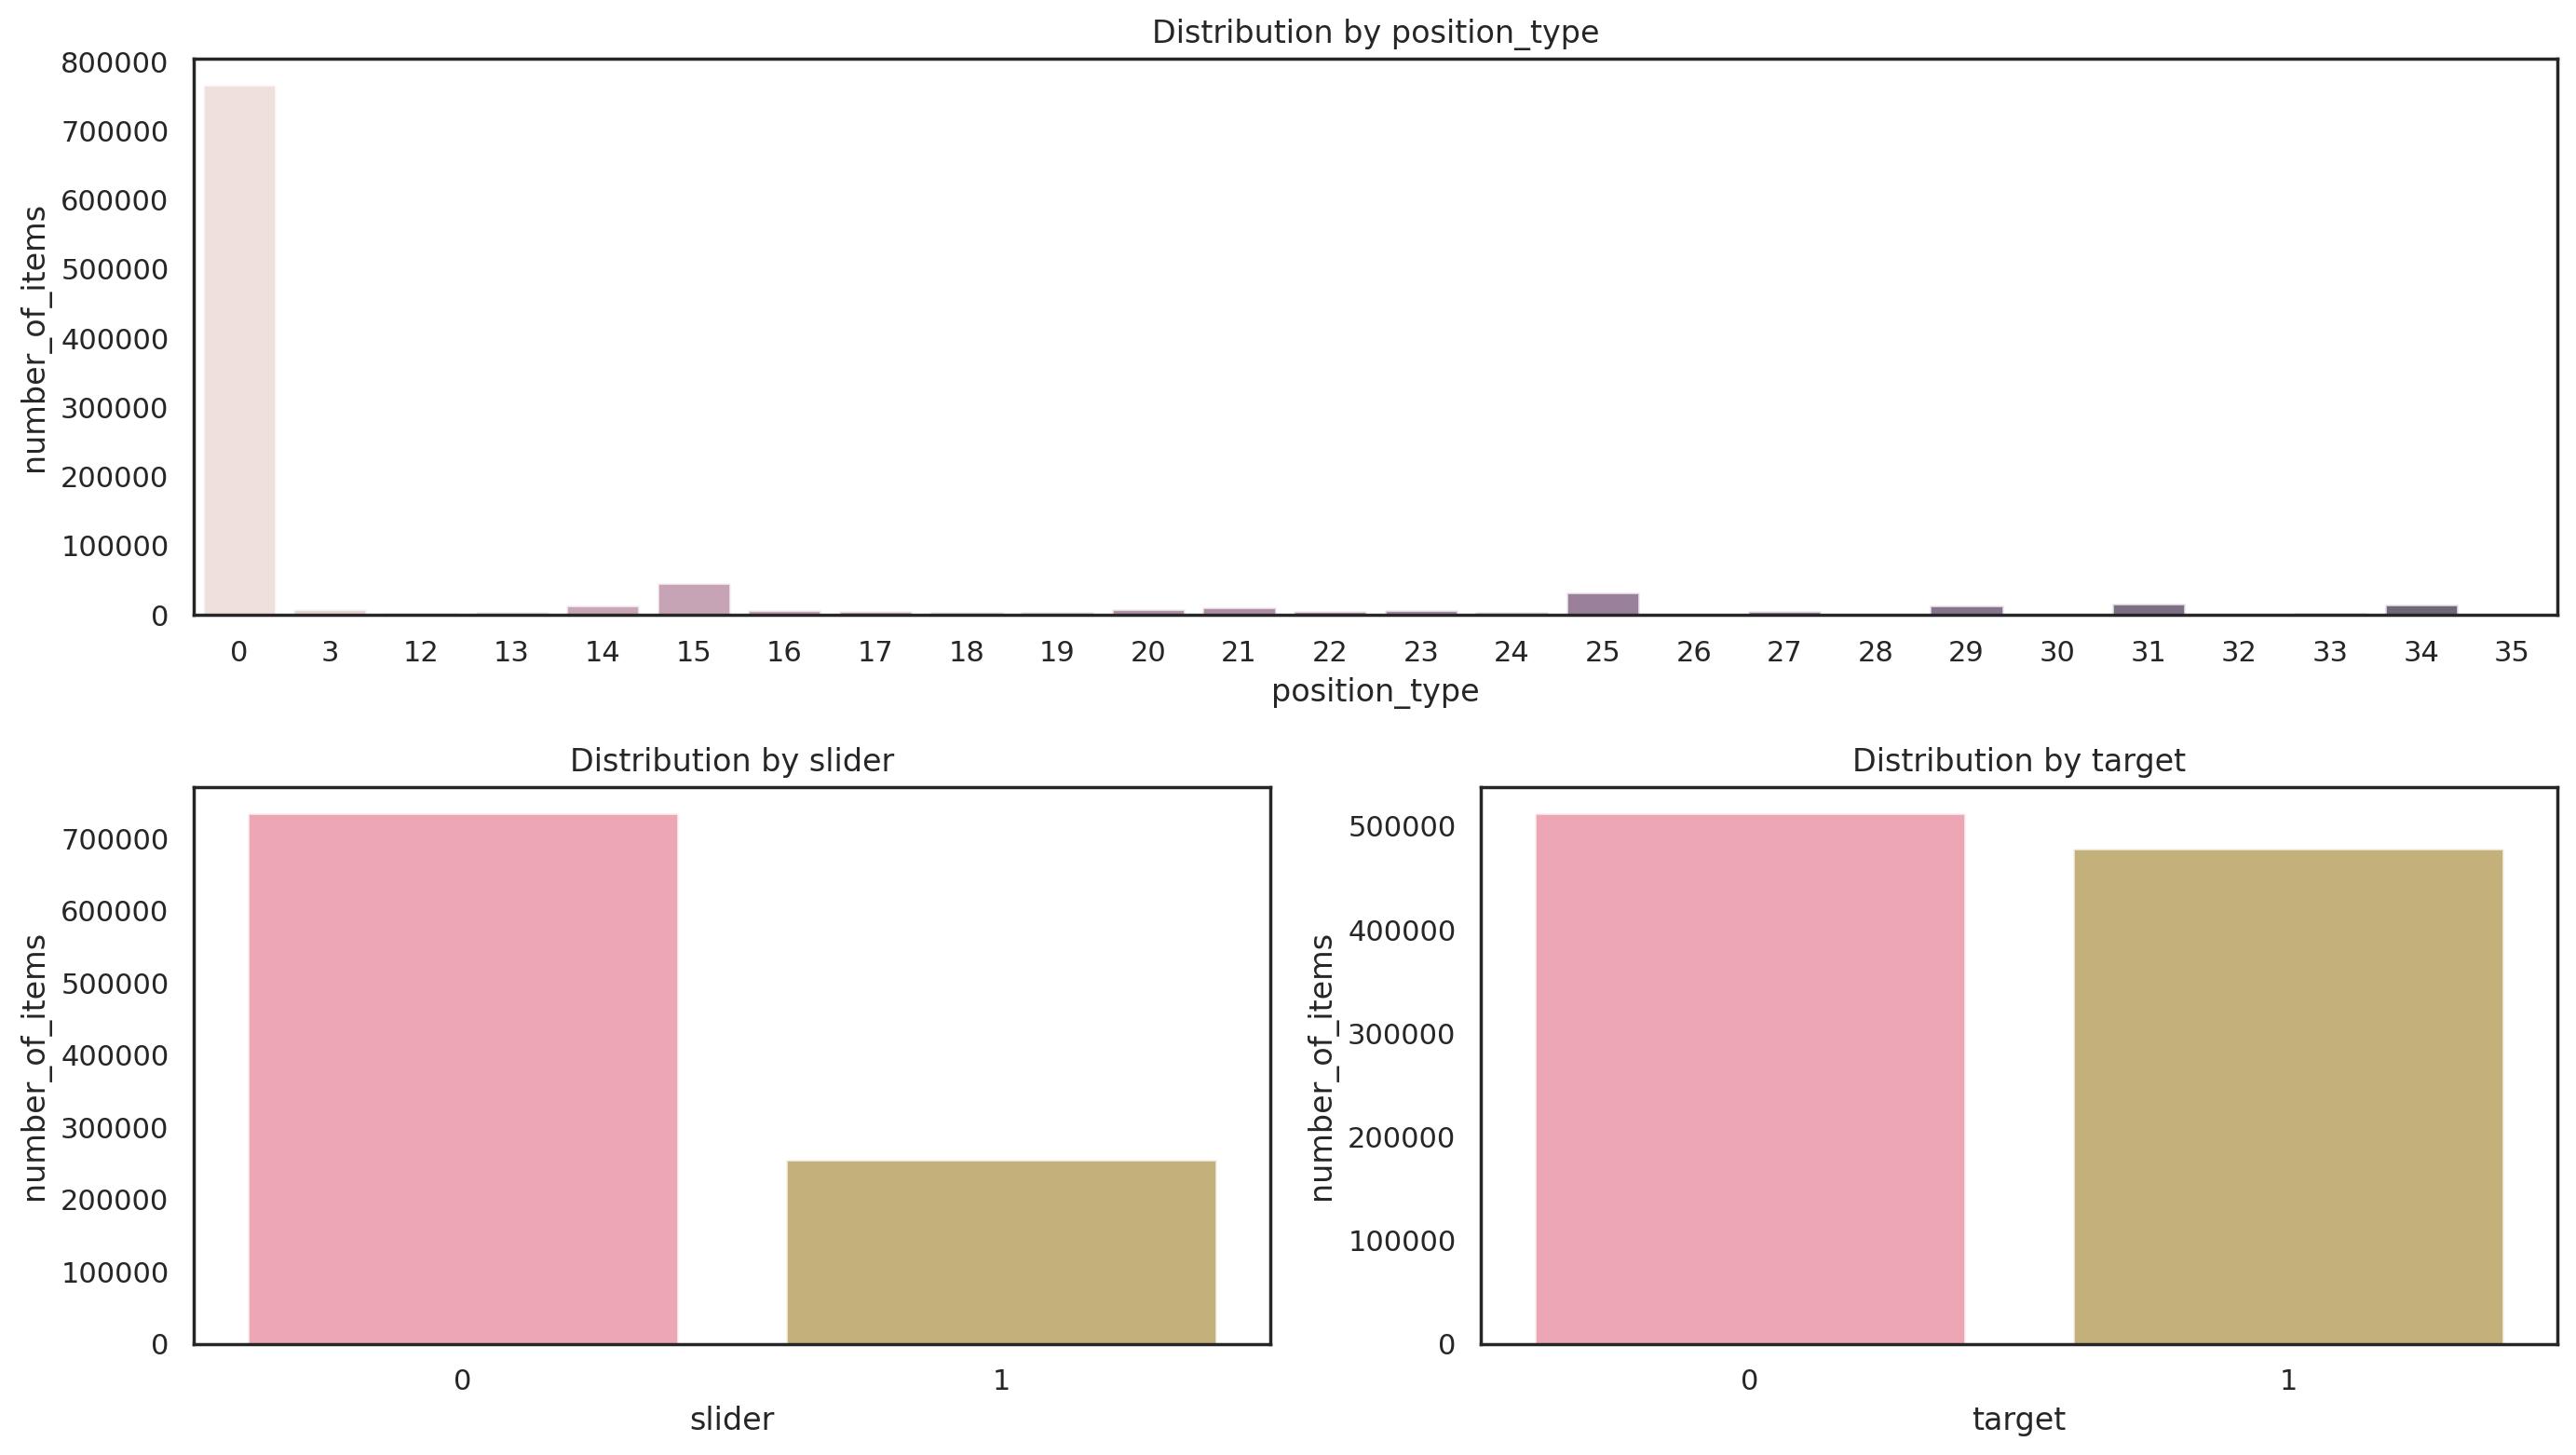

In [10]:
def plot_distribution(ax, data, title):
    sns.barplot(x=data.index,
                y=data.values,
                hue=data.index,
                ax=ax,
                alpha=0.7,
                legend=False)
    ax.set_ylabel('number_of_items')
    ax.set_title(title)

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, figure=fig)

titles = ['Distribution by position_type', 'Distribution by slider', 'Distribution by target']
data_columns = ['position_type', 'slider', 'target']

for i, (title, column) in enumerate(zip(titles, data_columns)):
    ax = fig.add_subplot(gs[i, :]) if i == 0 else fig.add_subplot(gs[1, i-1])
    plot_distribution(ax, df[column].value_counts(), title)

plt.savefig(os.path.join(ASSETS_DIR, 'Distribution by categories in the position_type, slider, target.png'))
plt.tight_layout()
plt.show()

### Анализ целевой переменной в зависимости от различных признаков

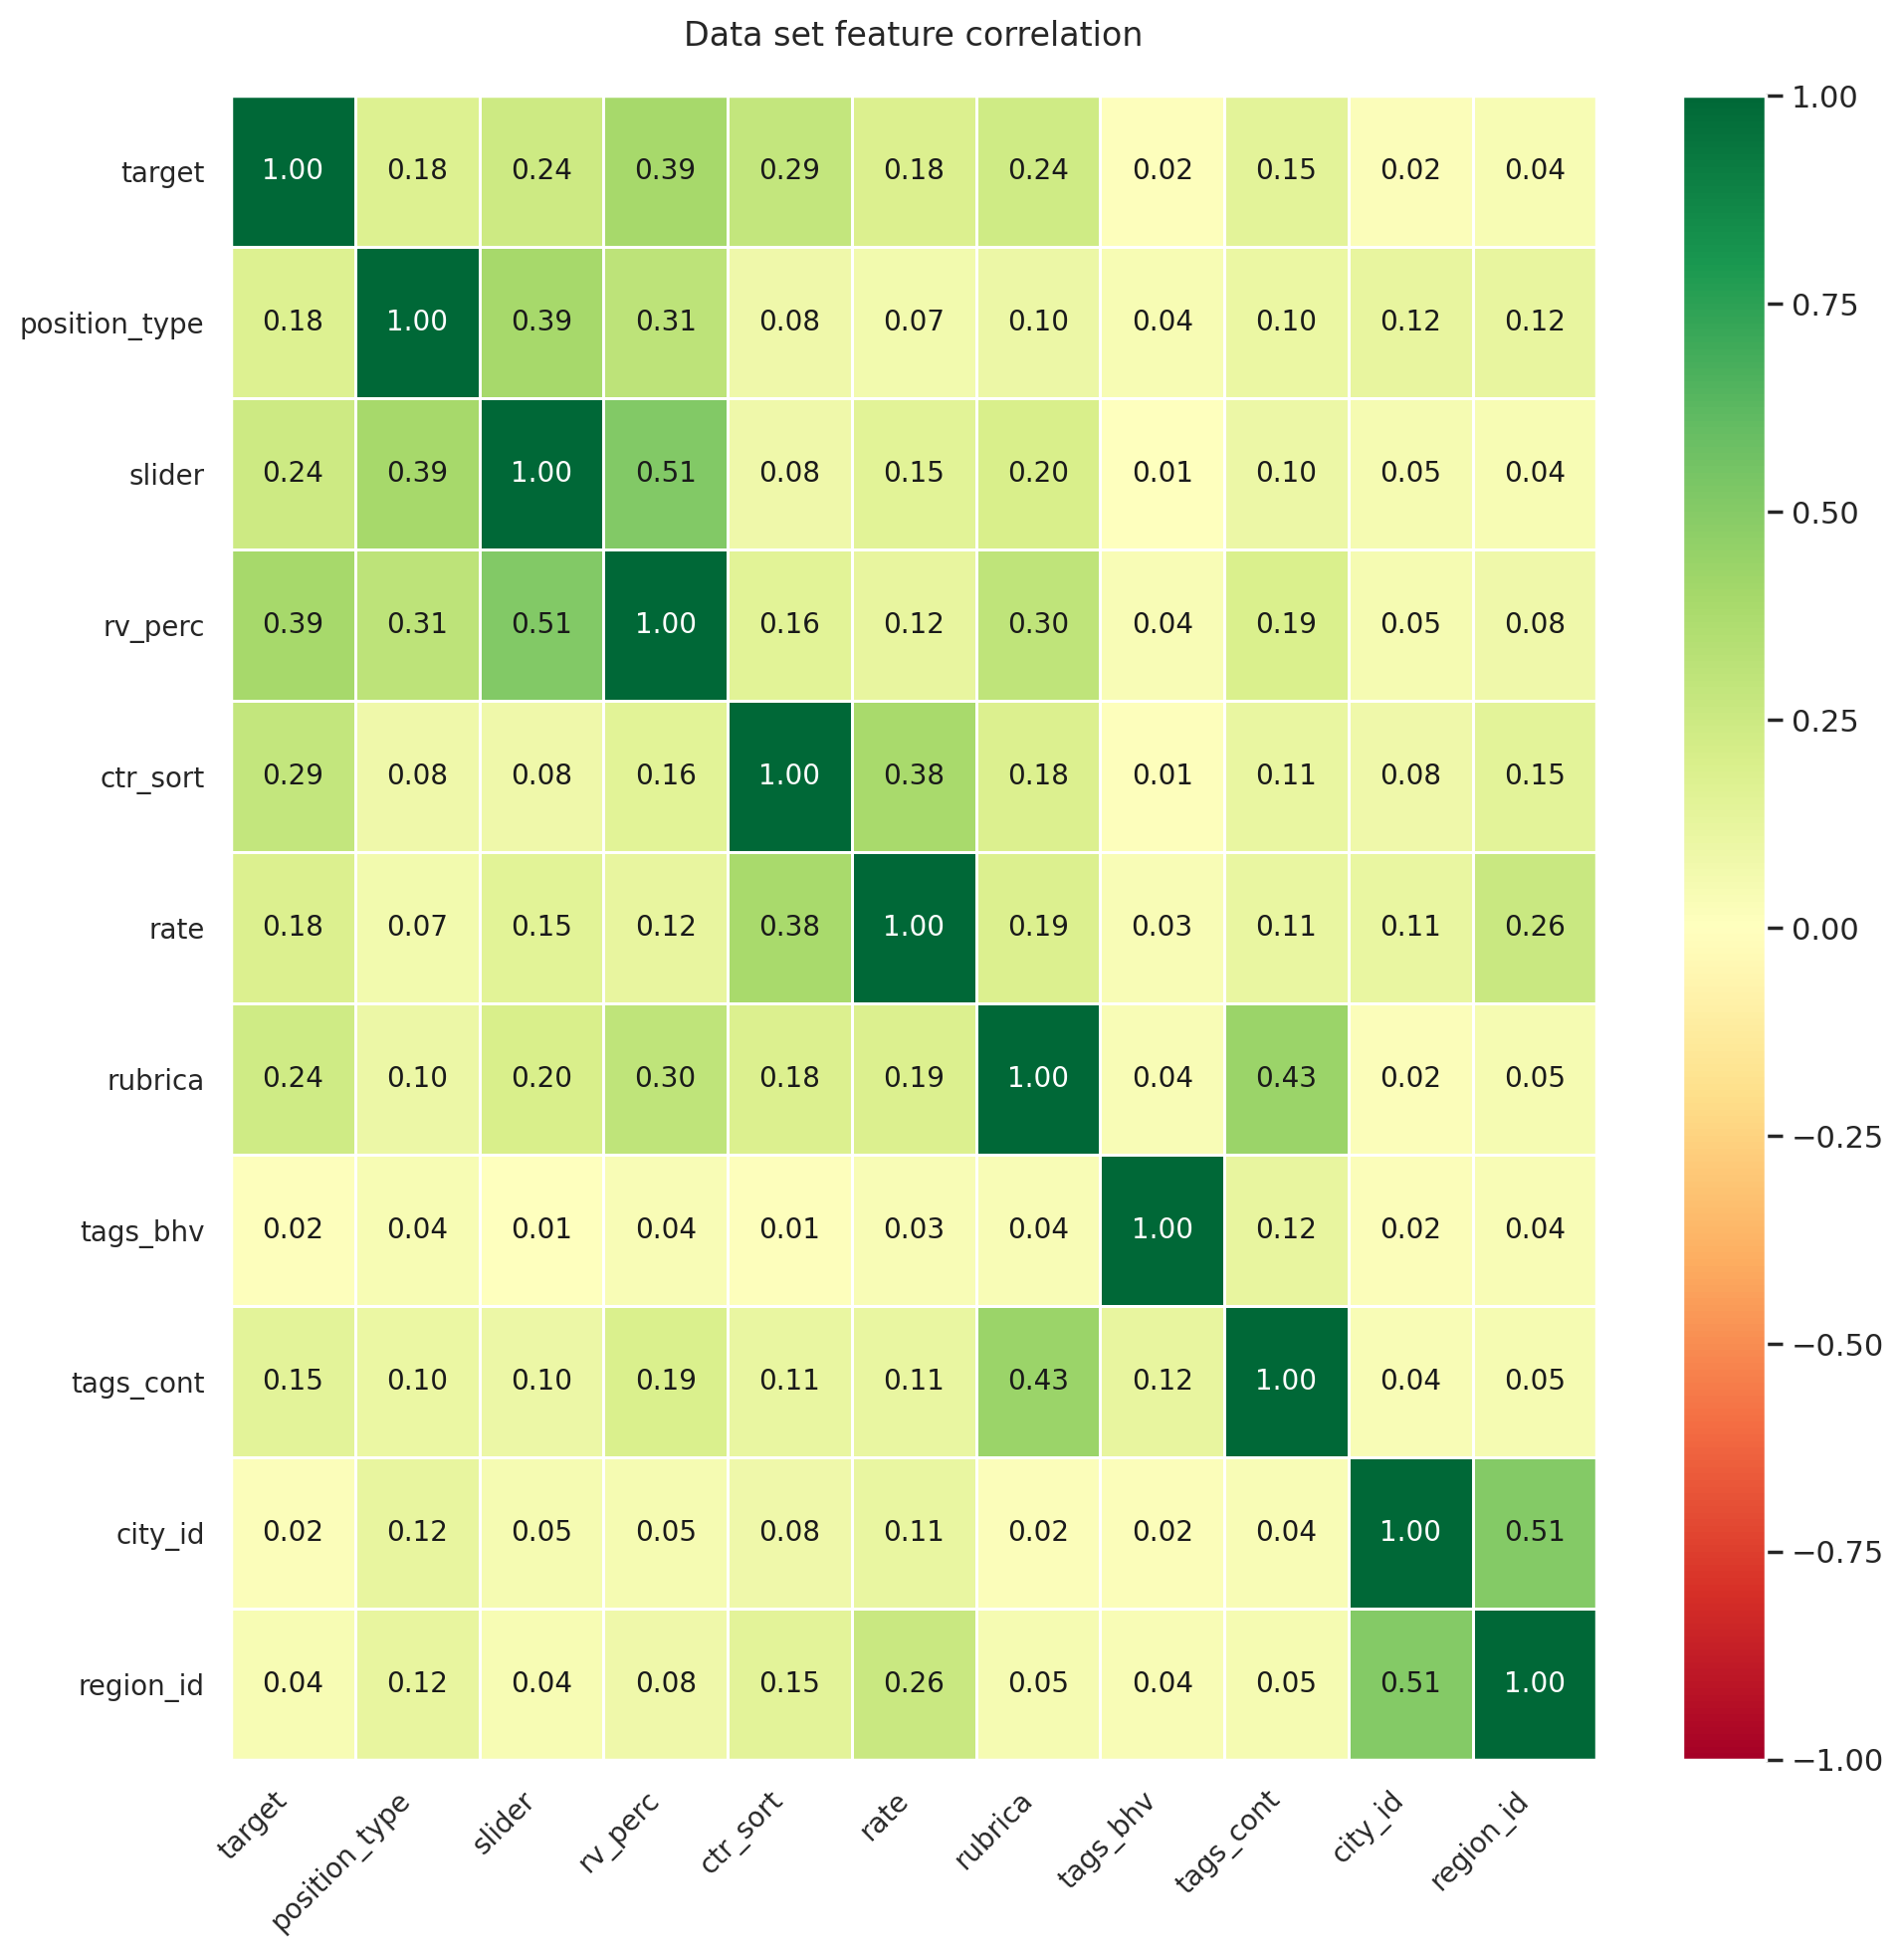

In [11]:
phik_overview = df.phik_matrix(interval_cols=df.columns.to_list())
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(10, 10))
plt.xticks(rotation=45, ha='right')
plt.title(f'Data set feature correlation', fontsize=12, y=1.02)
plt.savefig(os.path.join(ASSETS_DIR, 'Dataset feature correlation.png'))
plt.tight_layout()

Сохранение датафрейма

In [17]:
# df.to_csv(os.path.join(DATA_DIR, 'clean_df.csv'))
df = pd.read_csv(os.path.join(DATA_DIR, 'clean_df.csv'), index_col='Unnamed: 0')

### Выводы
- в целевой переменной наблюдается незначительный дисбаланс классов;
- большой дисбаланс прослеживается в признаках `slider` и `position_type`;
- в признаке `position_type` почти все данные относятся к значению 0,
  <br>что делает данный признак малоинформативным кандидатом на исключение;
- изучение корреляций не выявило сильных скрытых зависимостей признаков с целевой переменной;
- между некоторыми признаками имеются небольшие логически объяснимые зависимости.

## Предобработка данных

In [20]:
def data_preprocessing(test_size=0.1, dataset=None, features=None, target=None, add_features=False):
    X_train, X_test, y_train, y_test = train_test_split(dataset[features],
                                                        dataset[target],
                                                        test_size=test_size,
                                                        random_state=RANDOM_STATE,
                                                        stratify=dataset[target])
    scaler = StandardScaler()
    X_train_scl = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scl = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    if add_features:
        transformations = transformations
        afc = AutoFeatClassifier(categorical_cols=categorical_features, feateng_steps=1, max_gb=2, transformations=transformations, n_jobs=-1)
        X_train_afc = afc.fit_transform(X_train, y_train)
        X_test_afc = afc.transform(X_test)
        print(f'размерности выборок: {X_train_afc.shape, X_test_afc.shape, y_train.shape, y_test.shape}')
        return X_train_afc, X_test_afc, y_train, y_test
    else:
        print(f'размерности выборок: {X_train_scl.shape, X_test_scl.shape, y_train.shape, y_test.shape}')
        return X_train_scl, X_test_scl, y_train, y_test

In [31]:
X_train_bl, X_test_bl, y_train, y_test = data_preprocessing(test_size=TEST_SIZE,
                                                            dataset=df,
                                                            features=df.drop(['position_type', 'target'], axis=1).columns.tolist(),
                                                            target='target',
                                                            add_features=False)

размерности выборок: ((891349, 9), (99039, 9), (891349,), (99039,))


## Построение baseline

In [52]:
def model_fitting(model_name=None, features_train=None, target_train=None, n_splits=None, params=None):
    if model_name == 'Baseline' or model_name == 'Logistic Regression':
        model = LogisticRegression(**params)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(**params)
    model.fit(features_train.values, target_train.values)
    cv_strategy = StratifiedKFold(n_splits=n_splits)
    cv_res = cross_validate(model,
                            features_train,
                            target_train,
                            cv=cv_strategy,
                            n_jobs=-1,
                            scoring=['roc_auc', 'f1_micro', 'f1', 'f1_weighted', 'f1_macro'])
    for key, value in cv_res.items():
        cv_res[key] = round(value.mean(), 3)
    print(f"результаты кросс-вадидации: {cv_res}")
    y_pred = model.predict(features_train.values)
    y_pred_proba = model.predict_proba(features_train.values)[:, 1]
				
    roc_auc_value = roc_auc_score(target_train, y_pred_proba)
    f1_value = f1_score(target_train, y_pred)

    fpr, tpr, thresholds = roc_curve(target_train, y_pred_proba)
    plt.plot(fpr, tpr, linewidth=1.5, label='ROC-AUC (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1.5, label='random_classifier')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title(f'{model_name} Receiver Operating Characteristic', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(os.path.join(ASSETS_DIR, f'{model_name} Receiver Operating Characteristic.png'))
    plt.show()

    return cv_res['test_f1'], cv_res['test_roc_auc'], model

результаты кросс-вадидации: {'fit_time': 3.725, 'score_time': 0.634, 'test_roc_auc': 0.734, 'test_f1_micro': 0.669, 'test_f1': 0.652, 'test_f1_weighted': 0.669, 'test_f1_macro': 0.668}


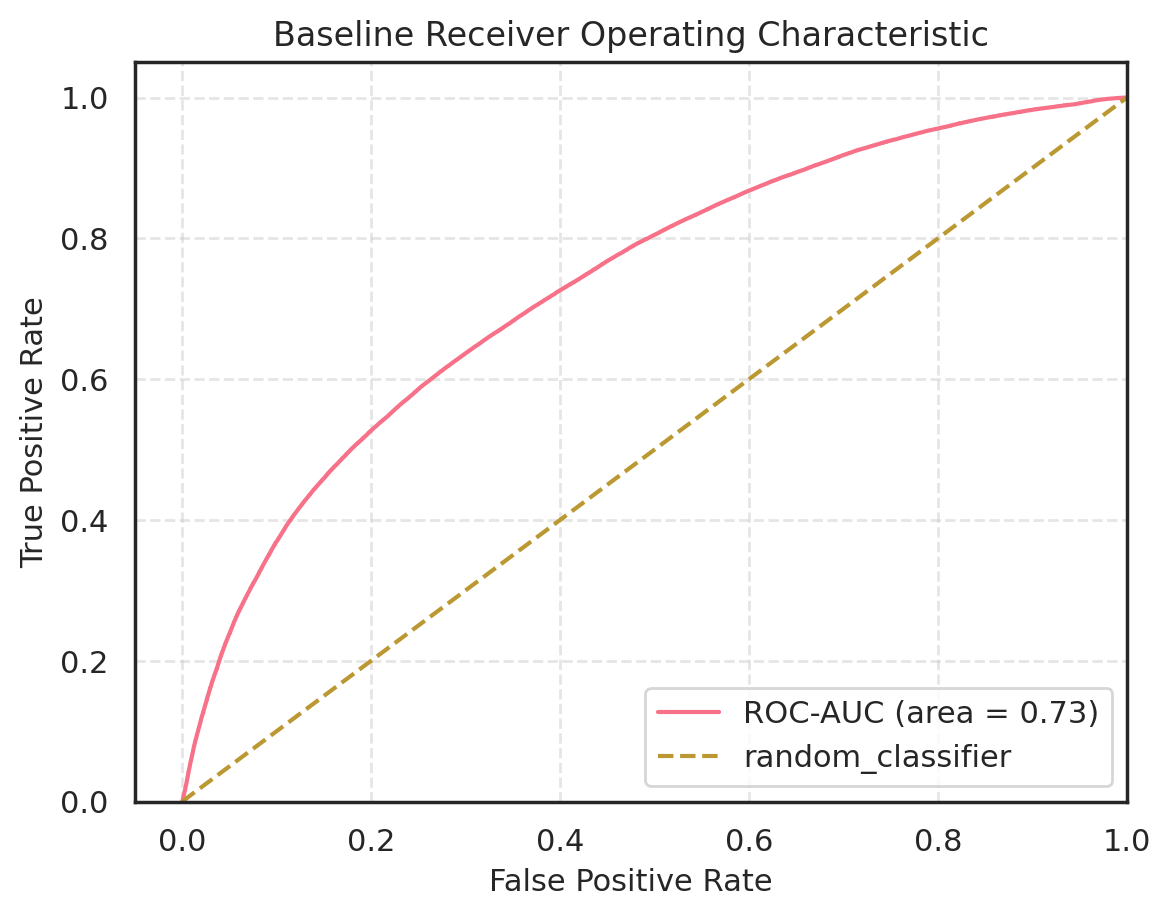

In [53]:
baseline_params = {'class_weight': 'balanced',
                   'C': 1.0,
                   'penalty': 'l2',
                   'max_iter': 1000,
                   'random_state': RANDOM_STATE}
f1_bl, roc_auc_bl, baseline = model_fitting(model_name='Baseline',
                                            features_train=X_train_bl,
                                            target_train=y_train,
                                            n_splits=round(X_train_bl.shape[0]/X_test_bl.shape[0]),
                                            params=baseline_params)

Логирование результатов

In [81]:
signature = mlflow.models.infer_signature(X_train_bl, y_train)
input_example = X_train_bl[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-14",
    "data_used": 'clean_common_df',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0"}
}
metrics_bl = {'f1_score': f1_bl, 'roc_auc_score': roc_auc_bl}

In [86]:
def model_logging(signature=None, input_example=None, metadata=None, metrics=None, model=None, params=None, run_name=None, reg_model_name=None):
    mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
    mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    experiment_id = mlflow.set_experiment(EXPERIMENT_NAME).experiment_id

    pip_requirements = 'requirements.txt'
    code_paths = ['ad_click_prediction.ipynb']

    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path='artifacts',
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            metadata=metadata,
            code_paths=code_paths,
            registered_model_name=reg_model_name,
            await_registration_for=60
        )

    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    run = mlflow.get_run(run_id)
    assert run.info.status == "FINISHED"

In [87]:
model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_bl,
              model=baseline,
              params=baseline_params,
              run_name='baseline_0_registry',
              reg_model_name='baseline_scope')

Successfully registered model 'baseline_scope'.
2024/06/14 11:03:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: baseline_scope, version 1
Created version '1' of model 'baseline_scope'.


Визуализация залогированных данных

In [108]:
def models_comparison(save_figure=False):
    connection.update(postgres_credentials)
    with psycopg.connect(**connection) as conn:
        with conn.cursor() as cur:
            cur.execute('''
                    SELECT
                      experiments.name AS experiment_name,
                      runs.name AS run_name,
                      model_versions.name AS model_name,
                      model_versions.version AS model_version,
                      MAX(CASE WHEN metrics.key = 'f1_score' THEN metrics.value END) AS f1_score,
                      MAX(CASE WHEN metrics.key = 'roc_auc_score' THEN metrics.value END) AS roc_auc_score
                    FROM experiments
                      LEFT JOIN runs USING (experiment_id)
                      LEFT JOIN metrics USING (run_uuid)
                      LEFT JOIN model_versions ON model_versions.run_id=runs.run_uuid
                    WHERE
                      experiments.name = %s
                      AND model_versions.name IS NOT Null
                    GROUP BY
                      experiments.name,
                      runs.name,
                      model_versions.name,
                      model_versions.version
                    ORDER BY roc_auc_score
                    ''', (EXPERIMENT_NAME,))
            table_data = cur.fetchall()
            table_columns = [desc[0] for desc in cur.description]
            print('Models and their metrics:')
            models_data = pd.DataFrame(table_data, columns=table_columns)
            display(models_data)
    plt.figure(figsize=(12, 6))
    metrics = ['f1_score', 'roc_auc_score']

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        sns.barplot(x='model_name', y=metric, data=models_data)
        plt.title(f'Comparison of {metric.upper()}')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    if save_figure:
        plt.savefig(os.path.join(ASSETS_DIR, f'Comparison of model metrics.png'))
    plt.show()

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734


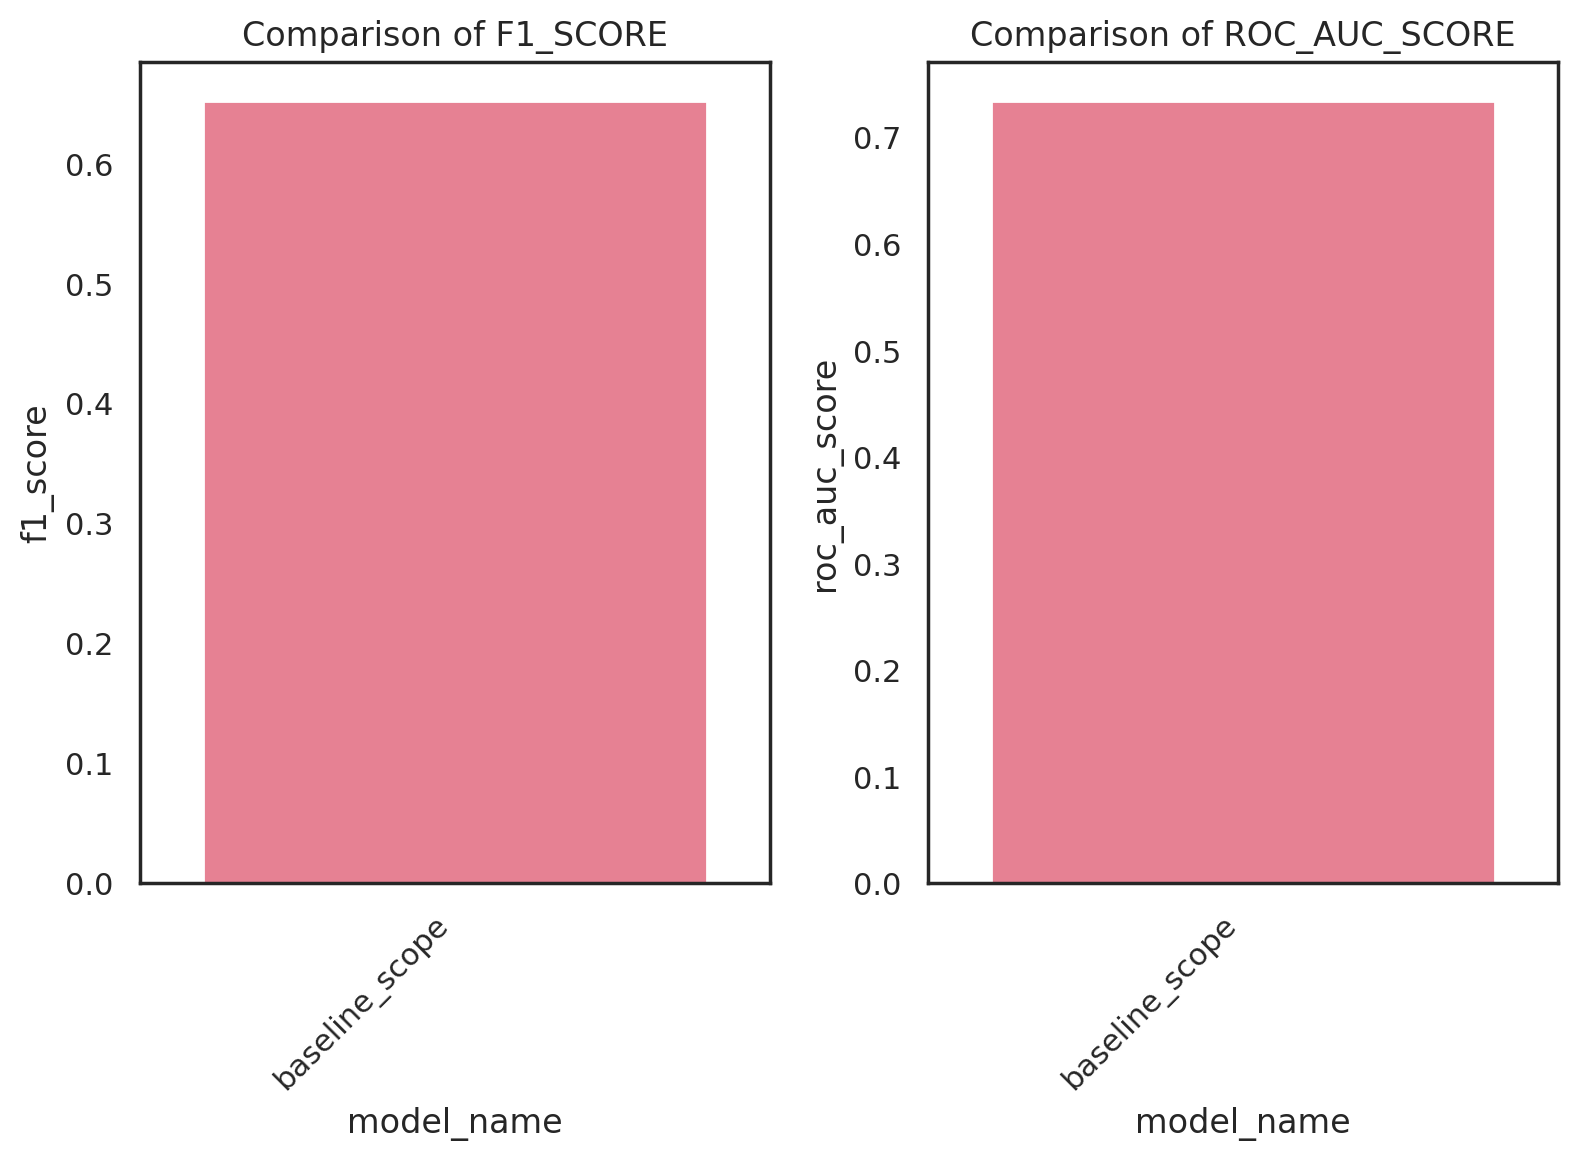

In [110]:
models_comparison(save_figure=True)

### Вывод
- в качестве baseline принята модель логистической регрессии с гиперпараметрами по умолчанию;
- получены базовые метрики: `ROC AUC = 0.734`, `F1 = 0.652`